In [15]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
import seawater


In [2]:
import sys
sys.path.insert(0,'/gpfswork/rech/egi/rote001/git/validation-TSprofiles/stat_comp')
sys.path.insert(0,'/gpfswork/rech/egi/rote001/git/validation-TSprofiles/param')

import stat_comp as sc
import param_all_profiles_MEDWEST60_1an_jz as param


In [3]:
params = {
    'config':param.config,
    'case':param.case,
    'member':param.member,
    'dirmod':param.dirmod,
    'coordfile':param.coordfile,
    'maskfile':param.maskfile,
    'hgrfile':param.hgrfile,
    'zgrfile':param.zgrfile,
    'batfile':param.batfile,
    'namlatmod':param.namlatmod,
    'namlonmod':param.namlonmod,
    'namdepmod':param.namdepmod,
    'nammaskmod':param.nammaskmod,
    'namtempmod':param.namtempmod,
    'namsaltmod':param.namsaltmod,
    'ymin':param.ymin,
    'mmin':param.mmin,
    'dmin':param.dmin,
    'ymax':param.ymax,
    'mmax':param.mmax,
    'dmax':param.dmax,
    'depthmin':param.depthmin,
    'radius_max':param.radius_max,
    'period':param.period,
    'number_of_model_profiles':param.number_of_model_profiles,
    'plotdir':param.plotdir,
    'ncdir':param.ncdir,
    'dmap':param.dmap,
    'sosie_exec':param.sosie_exec}

In [4]:
datemin=datetime.date(params['ymin'],params['mmin'],params['dmin'])+datetime.timedelta(days=params['period'])
datemax=datetime.date(params['ymax'],params['mmax'],params['dmax'])-datetime.timedelta(days=params['period'])

netcdf_file=params['ncdir']+'/ARGO_profiles_selection_and_model_colocation_for_'+str(params['config'])+'-'+str(params['case'])+'_'+str(datemin)+'-'+str(datemax)+'_'+str(params['depthmin'])+'m_'+str(params['radius_max'])+'x'+str(params['period'])+'d_'+str(params['number_of_model_profiles'])+'.nc'
ds_profiles=xr.open_dataset(netcdf_file)

In [5]:
ds_profiles

<xarray.Dataset>
Dimensions:             (DEPTH_MOD: 212, N_LEVELS: 155, N_PROF: 161, t: 1)
Coordinates:
  * N_PROF              (N_PROF) int64 529 402 17 194 136 ... 314 481 554 241
  * N_LEVELS            (N_LEVELS) int64 0 1 2 3 4 5 ... 149 150 151 152 153 154
    LATITUDE            (N_PROF) float64 ...
    LONGITUDE           (N_PROF) float64 ...
    TIME                (N_PROF) datetime64[ns] ...
Dimensions without coordinates: DEPTH_MOD, t
Data variables:
    CYCLE_NUMBER        (N_PROF) int64 ...
    DATA_MODE           (N_PROF) object ...
    DIRECTION           (N_PROF) object ...
    PLATFORM_NUMBER     (N_PROF) int64 ...
    POSITION_QC         (N_PROF) int64 ...
    PRES                (N_PROF, N_LEVELS) float64 ...
    PRES_QC             (N_PROF) int64 ...
    PSAL                (N_PROF, N_LEVELS) float64 ...
    PSAL_QC             (N_PROF, N_LEVELS) int64 ...
    TEMP                (N_PROF, N_LEVELS) float64 ...
    TEMP_QC             (N_PROF) int64 ...
    TIME_QC             (N_PROF) int64 ...
    index_i_model       (N_PROF) int64 ...
    index_j_model       (N_PROF) int64 ...
    model_levels        (t, DEPTH_MOD) float64 ...
    profile_temp_model  (N_PROF, DEPTH_MOD) float32 ...
    profile_salt_model  (N_PROF, DEPTH_MOD) float32 ...
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           rote001
    Fetched_date:         2020/09/09
    Fetched_constraints:  phy_[x=-5.68/9.60; y=34.85/45.14; z=0.0/12000.0; t=...
    Fetched_uri:          https://www.ifremer.fr/erddap/tabledap/ArgoFloats.n...
    history:              Variables filtered according to DATA_MODE; Variable...

In [69]:
def plot_one_profile(nprof):
    ds=xr.open_dataset(params['coordfile'])
    lat=ds[params['namlatmod']]
    lon=ds[params['namlonmod']]
    dsm=xr.open_dataset(params['maskfile'])
    tmask=dsm[params['nammaskmod']]
    dsb=xr.open_dataset(params['batfile'])
    bathy=dsb['Bathymetry']
    bathy_mask=np.ma.masked_where(tmask[0,0]==0.,bathy)
    latargo=ds_profiles['LATITUDE'][nprof]
    presargo=ds_profiles['PRES'][nprof]
    depthargo=seawater.dpth(presargo,latargo)
    latmin,latmax,lonmin,lonmax=(lat.min(),lat.max(),lon.min(),lon.max())
    

    fig = plt.figure(figsize=(15, 15))
    ax0=plt.subplot(221, projection=ccrs.PlateCarree())
    ax0.set_extent((lonmin, lonmax, latmin, latmax))
    pcolor=ax0.pcolormesh(lon,lat,bathy_mask,transform=ccrs.PlateCarree(),
                             cmap=cmocean.cm.deep,vmin=0,vmax=4000)
    ax0.coastlines(resolution="10m")
    gl = ax0.gridlines(draw_labels=True, linestyle=':', color='black',
                          alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax0.tick_params('both',labelsize=22)

    cbar = plt.colorbar(pcolor,orientation='vertical',shrink=0.75,label='m',ax=axs[0])
    

    ax0.scatter(ds_profiles.LONGITUDE[nprof], ds_profiles.LATITUDE[nprof], c='k', linewidth=5, s=20,label='ARGO profile');
    ax0.scatter(lon[ds_profiles.index_j_model[nprof].values,ds_profiles.index_i_model[nprof]].values, lat[ds_profiles.index_j_model[nprof],ds_profiles.index_i_model[nprof]].values, c='b', linewidth=2, s=12,label='model profile');
    ax0.legend()

    latargo=ds_profiles['LATITUDE'][nprof]
    presargo=ds_profiles['PRES'][nprof]
    depthargo=seawater.dpth(presargo,latargo)
    temp_model=ds_profiles.profile_temp_model[nprof]
    salt_model=ds_profiles.profile_salt_model[nprof]
    maxdepth=np.nanmax(depthargo)
    indmax=np.argmin(np.abs(maxdepth-ds_profiles.model_levels[0].values))
    max_temp=np.max([np.nanmax(ds_profiles.TEMP[nprof].values),np.nanmax(temp_model[0:indmax].values)])
    min_temp=np.min([np.nanmin(ds_profiles.TEMP[nprof].values),np.nanmin(temp_model[0:indmax].values)])
    max_salt=np.max([np.nanmax(ds_profiles.PSAL[nprof].values),np.nanmax(salt_model[0:indmax].values)])
    min_salt=np.min([np.nanmin(ds_profiles.PSAL[nprof].values),np.nanmin(salt_model[0:indmax].values)])
    
    ax1=plt.subplot(223)
    ax1.plot(ds_profiles.TEMP[nprof],depthargo,'k.-', label='temp argo')
    ax1.plot(ds_profiles.profile_temp_model[nprof],ds_profiles.model_levels[0],'b.-', label='temp model')
    ax1.set_ylabel('Depth [m]', size=14)
    ax1.set_ylim(np.nanmax(depthargo), 0)
    ax1.set_xlim(min_temp-1,max_temp+1)
    ax1.grid(True, which='both')
    ax1.xaxis.tick_top()
    ax1.xaxis.set_label_position('top') 
    ax1.legend()

    ax2=plt.subplot(224)
    ax2.plot(ds_profiles.PSAL[nprof],depthargo,'k.-', label='salt argo')
    ax2.plot(ds_profiles.profile_salt_model[nprof],ds_profiles.model_levels[0],'b.-', label='salt model')
    ax2.set_ylabel('Depth [m]', size=14)
    ax2.set_ylim(np.nanmax(depthargo), 0)
    ax2.set_xlim(min_salt-0.1,max_salt+0.1)
    ax2.grid(True, which='both')
    ax2.xaxis.tick_top()
    ax2.xaxis.set_label_position('top') 
    ax2.legend()
    
   

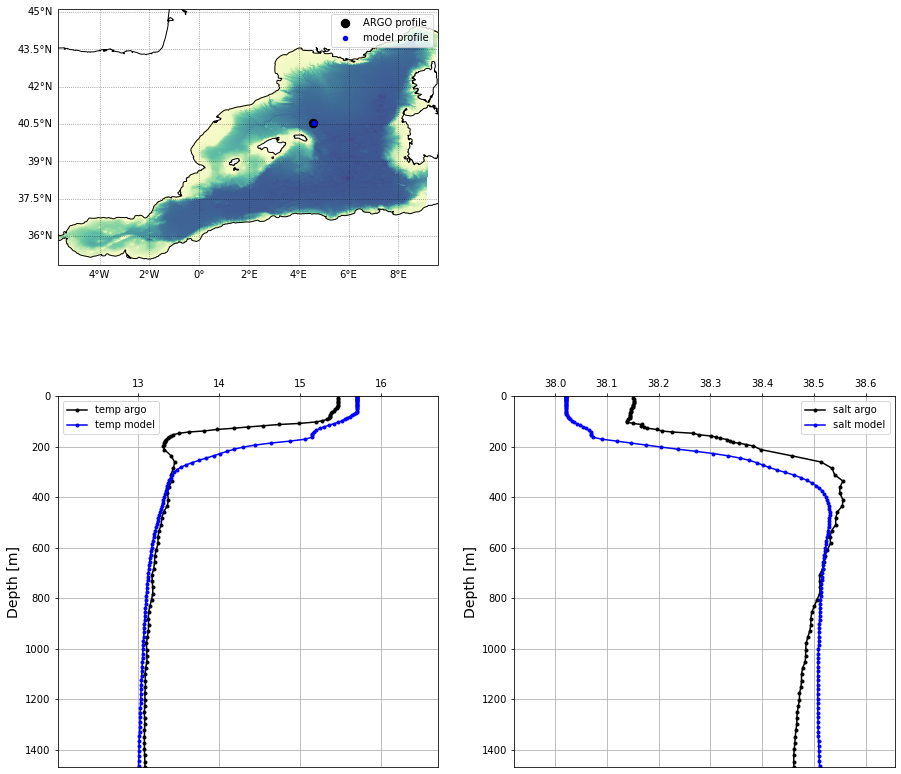

In [70]:
plot_one_profile(0)